Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

# Tutorial #1: Train a Vowpal Wabbit (VW) contextual bandit model with Azure Machine Learning

In a **contextual bandit** setup an agent tries to learn "a best course of action" from (previous) observations of a context, a selected action in that context, and the corresponding obtained reward.

In this tutorial, you train a VW contextual bandit model using an Azure Machine Learning (AML) Estimator on remote compute resources. You'll use the training workflow for AML in a Python Jupyter notebook. You can then use the notebook as a template to train your own contextual bandit model with your own data.

For this tutorial we use a synthetic dataset of coffee preferences. Each of the samples of this dataset represents an event in which a customer of a coffee shop has been offered a type of coffee, and the customer has expressed his satisfaction with that offering. The context is the customer and other event-associated features such as time-of-day, season, weather, and so forth. There are four actions to take (four types of coffee). The goal is to learn a model of customer preferences from a number of observations of such events. 

You can learn more about Vowpal Wabbit and contextual bandits [here](https://vowpalwabbit.org/).

In this notebook you will learn how to:
 > * Set up your development environment
 > * Create a dataset of files containing samples of contextual bandit data
 > * Access the dataset and explore some of the samples
 > * Train a VW contextual bandit model using an estimator
 > * Log training progression and view results
 
### Prerequisites
 
The user should have completed the Azure Machine Learning Tutorial. You will need to make sure that you have a valid subscription id, a resource group and a workspace. All datastores and datasets you use should be associated with your workspace. For detailed instructions see [Tutorial: Get started creating your first ML experiment](https://docs.microsoft.com/en-us/azure/machine-learning/tutorial-1st-experiment-sdk-setup).

## Set up your development environment

The following subsections show typical steps to setup your development environment. Setup includes:

* Connecting to a workspace to enable communication between your local machine and remote resources
* Creating an experiment to track all your runs
* Creating a remote compute target to use for training

### Azure ML SDK
 
Display the Azure ML SDK version.

In [1]:
import azureml.core

print("Azure ML SDK Version: ", azureml.core.VERSION)

Azure ML SDK Version:  1.4.0


### Connect to workspace

Create a workspace object from the existing workspace. `Workspace.from_config()` reads the file **config.json** and loads the details into an object named `ws` (see [documentation](https://docs.microsoft.com/en-us/python/api/azureml-core/azureml.core.workspace.workspace?view=azure-ml-py#from-config-path-none--auth-none---logger-none---file-name-none-) for details).  You may be asked to authenticate; in this case follow the instructions that appear in the output of this cell.

In [2]:
from azureml.core import Workspace

ws = Workspace.from_config()
print(ws.name, ws.location, ws.resource_group, sep=' | ')

zhenni-test-2 | canadacentral | zhenni-rg2


### Create experiment

Create an experiment to track the runs in your workspace. A workspace can have multiple experiments and each experiment can be used to track multiple runs. (see [documentation](https://docs.microsoft.com/en-us/python/api/azureml-core/azureml.core.experiment.experiment?view=azure-ml-py) for details.

In [3]:
from azureml.core.experiment import Experiment

experiment = Experiment(workspace=ws, name='vw-train-model')

### Create a new compute resource or attach an existing one

A compute target is a designated compute resource where you run your training script. This location may be your local machine or a cloud-based compute resource. The code below shows how to create a cloud-based compute target.

For more information see [What are compute targets in Azure Machine Learning?](https://docs.microsoft.com/en-us/azure/machine-learning/concept-compute-target)

**Note: Creation of a compute resource can take several minutes**

In [4]:
from azureml.core.compute import AmlCompute, ComputeTarget
import os

# choose a name and maximum size for your cluster
compute_name = os.environ.get("AML_COMPUTE_CLUSTER_NAME", "cpu-cluster")
compute_min_nodes = os.environ.get("AML_COMPUTE_CLUSTER_MIN_NODES", 0)
compute_max_nodes = os.environ.get("AML_COMPUTE_CLUSTER_MAX_NODES", 12)

vm_size = os.environ.get("AML_COMPUTE_CLUSTER_SKU", "STANDARD_D2_V2")

if compute_name in ws.compute_targets:
    print("Found an existing compute target of name: " + compute_name)
    compute_target = ws.compute_targets[compute_name]
    # note: you may want to make sure compute_target is of type AmlCompute        
else:
    print("Creating new compute target...")
    provisioning_config = AmlCompute.provisioning_configuration(
        vm_size=vm_size,
        min_nodes=compute_min_nodes, 
        max_nodes=compute_max_nodes)
        
    # create the cluster
    compute_target = ComputeTarget.create(ws, compute_name, provisioning_config)
    compute_target.wait_for_completion(show_output=True, min_node_count=None, timeout_in_minutes=20)

print(compute_target.get_status().serialize())

Creating new compute target...
Creating
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned
{'currentNodeCount': 0, 'targetNodeCount': 0, 'nodeStateCounts': {'preparingNodeCount': 0, 'runningNodeCount': 0, 'idleNodeCount': 0, 'unusableNodeCount': 0, 'leavingNodeCount': 0, 'preemptedNodeCount': 0}, 'allocationState': 'Steady', 'allocationStateTransitionTime': '2020-06-02T20:15:03.572000+00:00', 'errors': None, 'creationTime': '2020-06-02T20:14:55.481448+00:00', 'modifiedTime': '2020-06-02T20:15:11.209183+00:00', 'provisioningState': 'Succeeded', 'provisioningStateTransitionTime': None, 'scaleSettings': {'minNodeCount': 0, 'maxNodeCount': 12, 'nodeIdleTimeBeforeScaleDown': 'PT120S'}, 'vmPriority': 'Dedicated', 'vmSize': 'STANDARD_D2_V2'}


## Access and explore contextual bandit data
We have made the coffee dataset publicly available. Here we show how to get access to these data and look at some of the samples.

### Create a dataset from publicly available data files
The Dataset class is used to represent a resource for exploring and managing data in Azure Machine Learning. The following code shows how to create a file dataset from the files we have made publicly available on an Azure blob storage.

For more information see [Create Azure Machine Learning datasets](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-create-register-datasets)

In [5]:
from azureml.core import Dataset

# create a file dataset from sample data files stored in a public Azure blob storage container
coffee_ds = Dataset.File.from_files('https://stearlcbdeveastus001.blob.core.windows.net/cb-opendata/cb_synthetic/coffee/coffee_*')

### Explore sample contextual bandit data
We use the dataset object created above,`coffe_ds`, to explore the data and look at some of the samples. Later on we'll use this dataset to train a contextual bandit model. Run the code below to see the file paths in this dataset.

In [6]:
mount_context = coffee_ds.mount()
datafile_paths = coffee_ds.to_path()
print("Data files: ", datafile_paths)

Data files:  ['/coffee_1M.json', '/coffee_1M.txt', '/coffee_500K_1.json', '/coffee_500K_1.txt', '/coffee_500K_2.json', '/coffee_500K_2.txt']



The data in the coffee dataset are stored in two formats both acceptable by VW: **(1) VW DSJson format**, and **(2) VW Text format**. See [Vowpal Wabbit input format](https://github.com/VowpalWabbit/vowpal_wabbit/wiki/Input-format) for more details.

**DSJson Format**

DSJson format is composed of a dictionary of key-value pairs with some mandatory special keys and some additional, often optional, arbitrary keys. The order of the special keys also matters.

The following code fetches a sample of contextual bandit data in DSJson format. In this format, at the highest level 'c' represents the sample context under which '\_multi' key contains a list of possible actions in that context. Each item of '\_multi' represents a single action and can have its own id (or tag) and action-dependent features. All other properties under 'c' are considered as shared context between all actions ('Customer' in this example).

Both action-dependent and shared features could be enclosed by or represented under a namespace. In this example shared features are represented under 'Customer' namespace whereas the action-dependent features are divided between two namespaces: 'A_CoffeePrimary' and 'B_CoffeeAdditional'. As we'll see later, we can use these namespace to include or exclude features, or to create additional features when training a model. In general, namespaces can be nested to arbitrary levels, but VW uses the innermost namespaces for the purpose of such additional interactions.

'\_label_cost', '\_label_probability', '\_label_Action', and '\_labelIndex' are special properties which are showing cost, probability, index, and zero-based index of the selected action, respectively. 'p' is probabilities of the actions if available, and 'a' shows the ranks of actions rank based on their probabilities.

Run the code below to display a single sample from the DSJson file.

In [7]:
import json

jsonfiles = [f for f in datafile_paths if f.endswith('.json')]
mount_context.start()
print(mount_context.mount_point + jsonfiles[0])
with open(mount_context.mount_point + jsonfiles[0], 'r') as f:
    json_sample = f.readline()
    parsed = json.loads(json_sample)
    print('A Contextual Bandit data sample in DSJson Format:\n')
    print(json.dumps(parsed, indent=4))
mount_context.stop()

/tmp/tmpe5rff8bu/coffee_1M.json
A Contextual Bandit data sample in DSJson Format:

{
    "_label_cost": -0.6666666666666666,
    "_label_probability": 0.2,
    "_label_Action": 2,
    "_labelIndex": 1,
    "a": [
        2
    ],
    "c": {
        "Customer": {
            "name": "Bob",
            "weather": "Rainy",
            "timeofday": "Morning",
            "season": "Spring"
        },
        "_multi": [
            {
                "_tag": "Americano",
                "i": {
                    "id": "Americano"
                },
                "j": [
                    {
                        "A_CoffeePrimary": {
                            "type": "hot",
                            "roast": "medium"
                        }
                    },
                    {
                        "B_CoffeeAdditional": {
                            "origin": "ethiopia",
                            "organic": "yes"
                        }
                    }
        

**VW Multiline Text Format**

VW multi-line text format is an equivalent representation of DSJson format.

First line of an example in text format represents shared features, i.e. features that are shared between all the actions of the sample. Each of the following lines represent a single action and corresponding action-dependent features.

The selected action is identified by format of its label, which is of general form of action:cost:probability. Only one action (one row in each sample) is allowed to have a label of this form, and that is considered as the selected action.

Different samples are separated from each other by a single blank line in between.

Run the code below to display a single sample from the VW text data file.

In [8]:
textfiles = [f for f in datafile_paths if f.endswith('.txt')]
mount_context.start()
with open(mount_context.mount_point + textfiles[0], 'r') as f:
    multiline_text_sample = ''
    numline = 0
    while True:
        next_line = f.readline()
        numline += 1
        if next_line == '\n' or numline > 20:
            break
        multiline_text_sample += next_line        
    print('A Contextual Bandit sample in VW Multiline Text Format:\n')
    print(multiline_text_sample)
mount_context.stop()

A Contextual Bandit sample in VW Multiline Text Format:

shared |Customer name=Bob weather=Rainy timeofday=Morning season=Spring
Americano |A_CoffeePrimary type=hot roast=medium |B_CoffeeAdditional origin=ethiopia organic=yes
Cappucino:-0.6666666666666666:0.2 |A_CoffeePrimary type=hot roast=dark |B_CoffeeAdditional origin=kenya organic=yes
Coldbrew |A_CoffeePrimary type=cold roast=light |B_CoffeeAdditional origin=brazil organic=yes
Icedmocha |A_CoffeePrimary type=cold roast=light |B_CoffeeAdditional origin=ethiopia organic=no
Latte |A_CoffeePrimary type=hot roast=dark |B_CoffeeAdditional origin=brazil organic=no



## Train a VW Contextual Bandit model using an Azure ML Estimator
In this section we learn how to make a call to an estimator to invoke Vowpal Wabbit and supply the call with appropriate parameters for the purpose of counterfactual analysis. We also learn how to get access to trained model and briefly look at the training results.

### Estimator call to train VW model
Following code snippets show how to create an instance of Azure ML Estimator and supply it with appropriate set of parameters. We need to specify the following parameters:
- `source_directory`, local directory containing your training script(s) and helper modules,
- `entry_script`, path to your entry script relative to the source directory,
- `script_params`, constant parameters to be passed to each run of training script and then further down to VW,
- `inputs`, references to the training dataset and to the mount path on the compute node,
- `environment_definition`, which points to a curated environment for running Vowpal Wabbit (Please make sure to use this environment when running Vowpal Wabbit training in Azure Machine Learning. The default images don't have all necessary dependencies installed), and the
- `compute_target` in which the training jobs will be executed.

**VW model trainining parameters:**
In the code below `vw_params` specifies list of parameters we are passing down to VW. In particular, we are making a call to VW to train a model using data of **dsjson** format and **cb_adf** algorithm (see [this page](https://vowpalwabbit.org/tutorials/contextual_bandits.html#algorithms-and-format) for more on contextual bandit algorithms). Additionally, we are adding **\-q**, short for quadratics, to the list of parameters passed to VW. This parameter tells VW to create additional features relating Customer and A_CoffeePrimary, and Customer and B_CoffeeAdditional namespaces together. The first letter of the namespaces, CA and CB in this example, is used to represent and establish these bindings (see [this tutorial](https://vowpalwabbit.org/tutorials/cb_simulation.html) for more details). We typically can achieve higher rewards by supplying this parameter. Parameter **\-P**, short for Progress, shows frequency of logging learning metrics, in this case on every **10000** samples.

We use entry script parameters, `script_param`, to pass all these parameters in.

In [9]:
from azureml.core import Environment
from azureml.train.estimator import Estimator

# Obtain a reference to the Curated Environment for Vowpal Wabbit
vw_env = Environment.get(workspace=ws, name='AzureML-VowpalWabbit-8.8.0')

script_parameters = {
    '--vw_params': ' --cb_adf --dsjson -P 10000 -q CA CB'
}

cb_estimator = Estimator(
    source_directory='scripts',
    entry_script='cfa_simple.py',
    script_params=script_parameters,
    inputs=[coffee_ds.as_named_input('train_dataset'), coffee_ds.as_named_input('train_path').as_mount()],
    environment_definition=vw_env,
    compute_target=compute_target, # set to 'local' to run on your local machine
    node_count=1)

Now we can use the `experiment` created above to submit a run, and then subsequently wait for its result. Note that `RunDetails(run).show()` shows details of the run as it moves forward.

In [35]:
from azureml.widgets import RunDetails
from distutils.dir_util import copy_tree

# copy vw_executor script before submitting estimator for a run
copy_tree('../../scripts/vw_executor', './scripts/vw_executor')

# submit cb_estimator for a run
run = experiment.submit(cb_estimator)
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

Now we wait for the run to reach a terminal state. We could also cancel the run before completion.

In [11]:
# Uncomment line below to cancel the run before it completes, or otherwise wait for completion of the run
# run.cancel()
run.wait_for_completion()

{'runId': 'vw-train-model_1591128983_b5daf5de',
 'target': 'cpu-cluster',
 'status': 'Finalizing',
 'startTimeUtc': '2020-06-02T20:18:42.33327Z',
 'properties': {'_azureml.ComputeTargetType': 'amlcompute',
  'ContentSnapshotId': 'd614c170-4911-4a98-b336-2546750f859b',
  'ProcessInfoFile': 'azureml-logs/process_info.json',
  'ProcessStatusFile': 'azureml-logs/process_status.json'},
 'inputDatasets': [{'dataset': {'id': '5175ebe1-fb72-4b53-b5d1-6c35957dc739'}, 'consumptionDetails': {'type': 'RunInput', 'inputName': 'train_dataset', 'mechanism': 'Direct'}}, {'dataset': {'id': '5175ebe1-fb72-4b53-b5d1-6c35957dc739'}, 'consumptionDetails': {'type': 'RunInput', 'inputName': 'train_path', 'mechanism': 'Mount'}}],
 'runDefinition': {'script': 'cfa_simple.py',
  'useAbsolutePath': False,
  'arguments': ['--vw_params', ' --cb_adf --dsjson -P 10000 -q CA CB'],
  'sourceDirectoryDataStore': None,
  'framework': 'Python',
  'communicator': 'None',
  'target': 'cpu-cluster',
  'dataReferences': {},


### Where to find the trained model?
The model is stored under 'outputs' directory. You can use the following code to download the model.

In [12]:
# Downloads the Vowpal Wabbit model into the current directory
model_file_name = 'vw_model'

run.download_file(f'outputs/{model_file_name}')

### Obtaining and plotting the results
Section above shows details of the run as the result of `RunDetails(run).show()` statement. We can also get access to the results using different methods of [Run](https://docs.microsoft.com/en-us/python/api/azureml-core/azureml.core.run(class)?view=azure-ml-py) class. For example, the code bellow reads metric 'avg_loss_by example' and plots the loss (cost or reward) over the course of training. This metric was logged by training script on every 10000 samples (determined by VW parameter **\-P 10000**, short for Progress, passed in above).

<IPython.core.display.Javascript object>


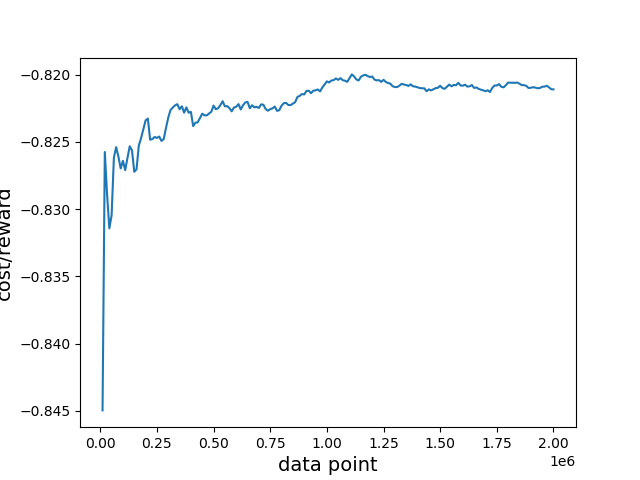

In [17]:
%matplotlib notebook
import matplotlib.pyplot as plt

metrics = run.get_metrics(name='avg_loss_by_example')

data_points = metrics['avg_loss_by_example']['count']
loss = metrics['avg_loss_by_example']['loss']

data_points, loss = zip(*[(s,l) for s,l in sorted(zip(data_points, loss))])

plt.plot(data_points, loss)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xlabel('data point', fontsize=14)
plt.ylabel('cost/reward', fontsize=14)
plt.show()

## Cleaning up

For your convenience, below you can find code snippets to clean up any resources created as part of this tutorial that you don't wish to retain.

In [14]:
# To remove vw_executor scripts copied to notebook scripts
from distutils.dir_util import remove_tree
import os
if os.path.exists('./scripts/vw_executor'):
    remove_tree('./scripts/vw_executor')

# To archive the created experiment:
#experiment.archive()

# To delete the compute target:
#compute_target.delete()

# To archive the training data set if you registered it in Azure Machine Learning:
#coffee_ds.unregister_all_versions()

# To clean up the downloaded model file
#import os
#os.remove(model_file_name)

## What is next?
TODO: Add links to Scoring and Sweeping tutorials.